# Quantitative exercise - NYU Depth V2 dataset

The goal of this exercise is computing some initial analysis and statistics of the datasets we identified for our project.

Our project concerns depth prediction from monocular 2D images: the independant variable are the images (usually in PNG or JPG format), whereas the dependant variable is the depth information (in meters). The ground truth depth information is usually computed from laser scanners. Nowadays the technology has become quite accurate, for example in systems such as [LiDAR](https://en.wikipedia.org/wiki/Lidar). In the case of this preliminary analysis, the dataset is quite old (approximately 2005) and a different laser scanner was used.

You can reproduce these results by downloading and extracting the [NYU-Depth V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) dataset in the same folder as this notebook before running this notebook.  

#### Author: Tianze Wang

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from scipy.stats import describe
import h5py
import numpy as np

In [2]:
def get_image(dataset, index):
    sample_depth = dataset['depths'][index].transpose()
    sample_raw_depth = dataset['rawDepths'][index].transpose()
    sample_img = dataset['images'][0]
    # reshape due to different order
    sample_img_ = np.empty([480, 640, 3])
    sample_img_[:,:,0] = sample_img[0,:,:].T
    sample_img_[:,:,1] = sample_img[1,:,:].T
    sample_img_[:,:,2] = sample_img[2,:,:].T
    sample_img_ = (sample_img_).astype('int')
    return sample_img_, sample_depth, sample_raw_depth

def visualize_image(img, depth, raw_depth):
    plt.figure(figsize=(20,6))
    plt.subplot(131).set_title("image", fontsize=20)
    plt.imshow(img)

    plt.subplot(132).set_title("depth", fontsize=20)
    img_depth = plt.imshow(depth)
    img_depth.set_cmap('nipy_spectral')
    plt.colorbar()

    plt.subplot(133).set_title("raw_depth", fontsize=20)
    img_raw_depth = plt.imshow(raw_depth)
    img_raw_depth.set_cmap('nipy_spectral')
    plt.colorbar()

def visualize_image_histogram(img, depth, raw_depth):
    plt.figure(figsize=(20,5))
    plt.subplot(131).set_title("hist of image", fontsize=20)
    plt.hist((img).ravel(), bins=256, range=(0, 255), density=True, fc='k', ec='k')

    plt.subplot(132).set_title("hist of depth", fontsize=20)
    plt.hist((depth).ravel(), density=True, fc='k', ec='k')

    plt.subplot(133).set_title("hist of raw_depth", fontsize=20)
    plt.hist((raw_depth).ravel(), density=True, fc='k', ec='k')

#borrowed from Andrea
def depth_stats(y, max_depth=999):
    stats = describe(y[y<max_depth])
    print(f"Range: {stats.minmax[0]:.2f}-{stats.minmax[1]:.2f}\nMean: {stats.mean:.3f}\nVariance: {stats.variance:.3f}\nSkewness: {stats.skewness:.3f}\nKurtosis: {stats.kurtosis:.3f}")

## NYU Depth V2 Dataset

The [NYU-Depth V2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html) data set is comprised of video sequences from a variety of indoor scenes as recorded by both the RGB and Depth cameras from the Microsoft Kinect. It features:

- 1449 densely labeled pairs of aligned RGB and depth images
- 464 new scenes taken from 3 cities
- 407,024 new unlabeled frames

Each object is labeled with a class and an instance number (cup1, cup2, cup3, etc)
The dataset has several components:

- Labeled: A subset of the video data accompanied by dense multi-class labels. This data has also been preprocessed to fill in missing depth labels.
- Raw: The raw rgb, depth and accelerometer data as provided by the Kinect.
- Toolbox: Useful functions for manipulating the data and labels.

In this analysis, we will work with **labeled dataset** which is a subset of the Raw Dataset. It is comprised of pairs of RGB and Depth frames that have been synchronized and annotated with dense labels for every image. In addition to the projected depth maps, the dataset also includes a set of preprocessed depth maps whose missing values have been filled in using the [colorization scheme of Levin et al](http://www.cs.huji.ac.il/~yweiss/Colorization/).
Some of data that is of interest to over research are the following:

- **depths** – HxWxN matrix of in-painted depth maps where H and W are the height and width, respectively and N is the number of images. The values of the depth elements are in meters.
- **images** – HxWx3xN matrix of RGB images where H and W are the height and width, respectively, and N is the number of images.
- **rawDepths** – HxWxN matrix of raw depth maps where H and W are the height and width, respectively, and N is the number of images. These depth maps capture the depth images after they have been projected onto the RGB image plane but before the missing depth values have been filled in. Additionally, the depth non-linearity from the Kinect device has been removed and the values of each depth image are in meters.

In [3]:
# load the matlab data file with h5py 
# as this particular version is not supported by scipy.io.loadmat
dataset_path = 'nyu_depth_v2_labeled.mat'
NYU_Depth_v2 = h5py.File(dataset_path, 'r')

## General information about the dataset

In [4]:
print('NYU_Depth_v2[\'images\'].shape', NYU_Depth_v2['images'].shape)
print('NYU_Depth_v2[\'depths\'].shape', NYU_Depth_v2['depths'].shape)
print('NYU_Depth_v2[\'rawDepths\'].shape', NYU_Depth_v2['rawDepths'].shape)

NYU_Depth_v2['images'].shape (1449, 3, 640, 480)
NYU_Depth_v2['depths'].shape (1449, 640, 480)
NYU_Depth_v2['rawDepths'].shape (1449, 640, 480)


As can be seen from the previous step, the dataset contains 1499 images.

The **image** is storing the image in a channel first manner which requires some manipulation when using pyplot to show the image.

The **depth** and **raw_depth** are rather trivial to understand.

## Sample image demonstration

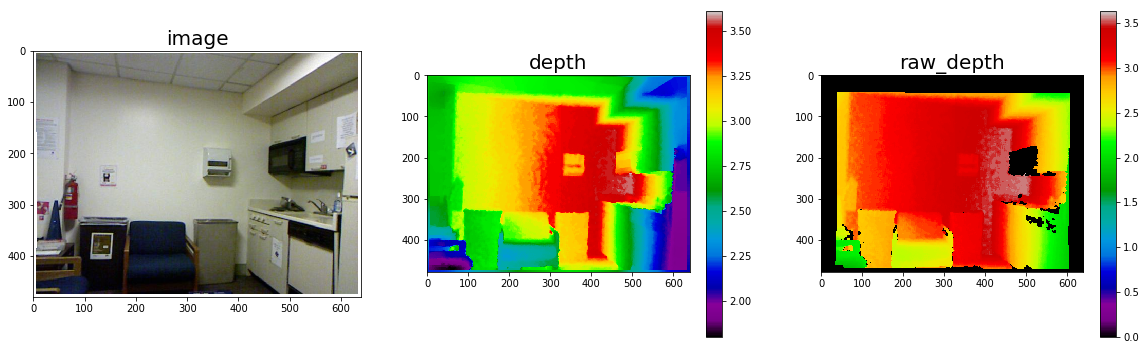

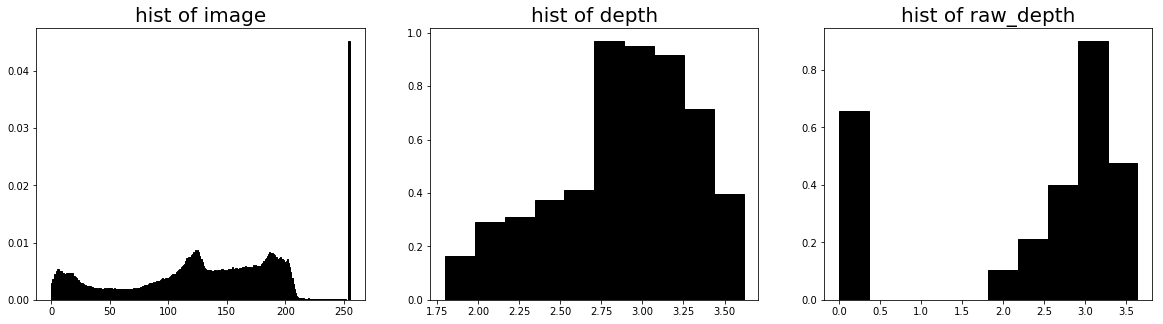

In [5]:
img, depth, raw_depth = get_image(NYU_Depth_v2, 0)
visualize_image(img, depth, raw_depth)
visualize_image_histogram(img, depth, raw_depth)

In [6]:
depth_stats(depth)

Range: 1.80-3.62
Mean: 2.880
Variance: 0.177
Skewness: -0.550
Kurtosis: -0.481


In [7]:
depth_stats(raw_depth)

Range: 0.00-3.64
Mean: 2.271
Variance: 1.731
Skewness: -1.018
Kurtosis: -0.715


As can be seen from the raw depth map, some of the values are missing. And the NYU Depth V2 dataset using this method [colorization scheme of Levin et al](http://www.cs.huji.ac.il/~yweiss/Colorization/) to calculate the missing value. And this could be seen as a preprocessing step.

In the mean time, it could be interesting to see how these calculated values could affect the prediction of our model.

/home/bw/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


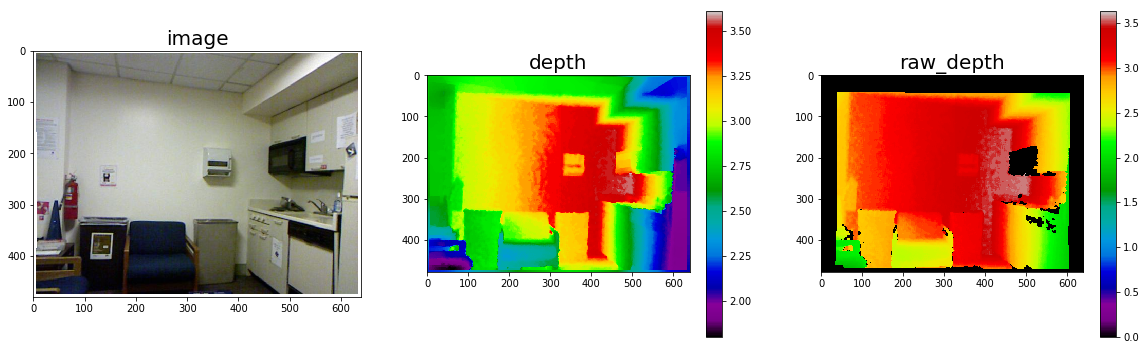

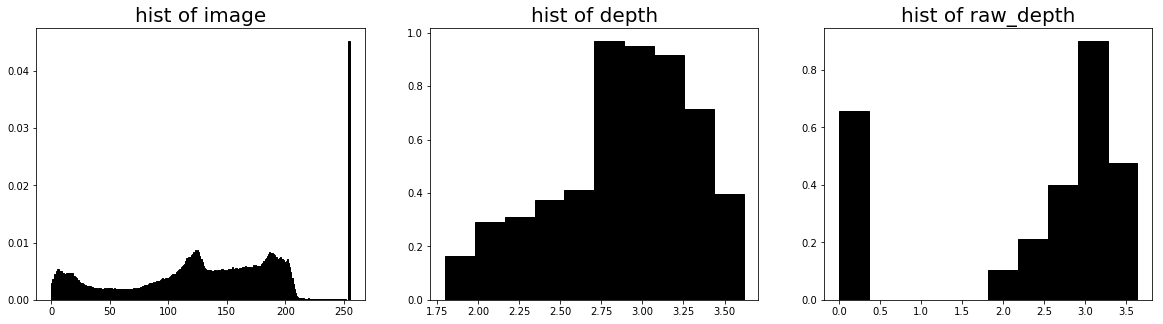

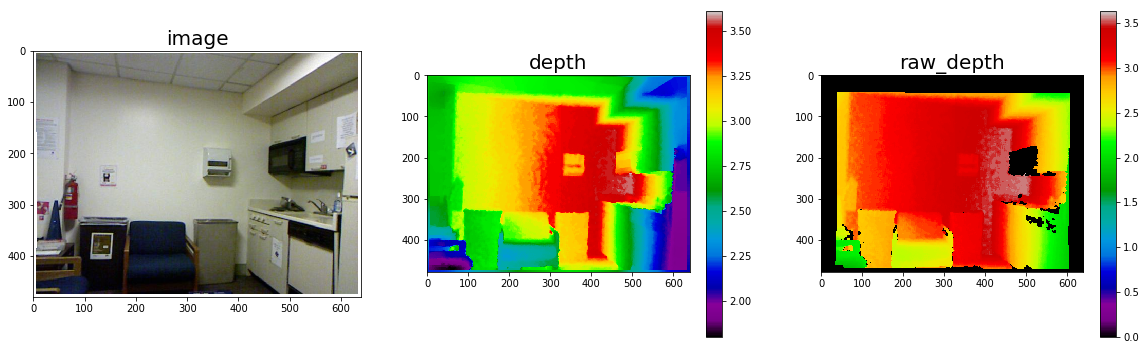

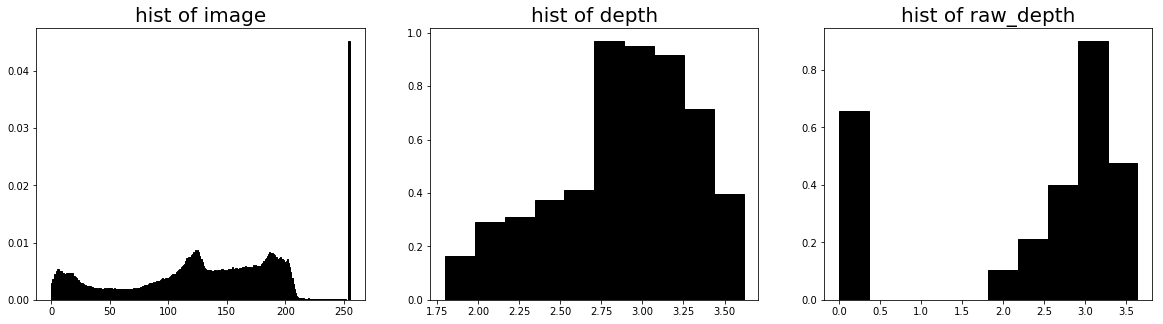

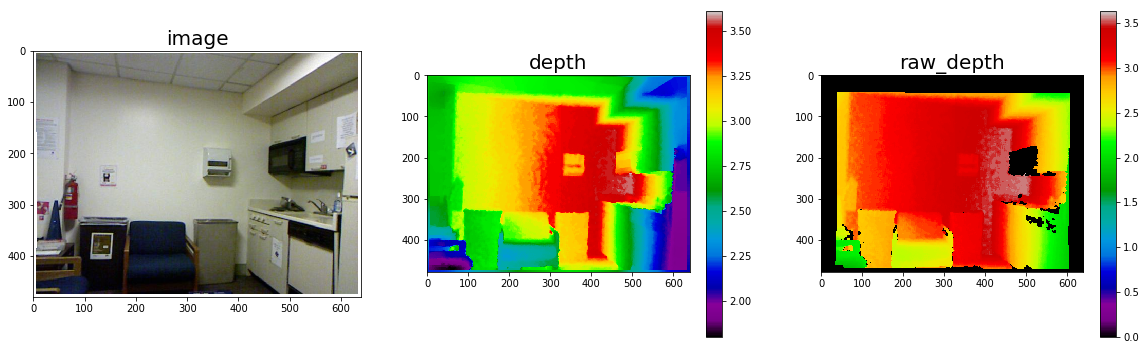

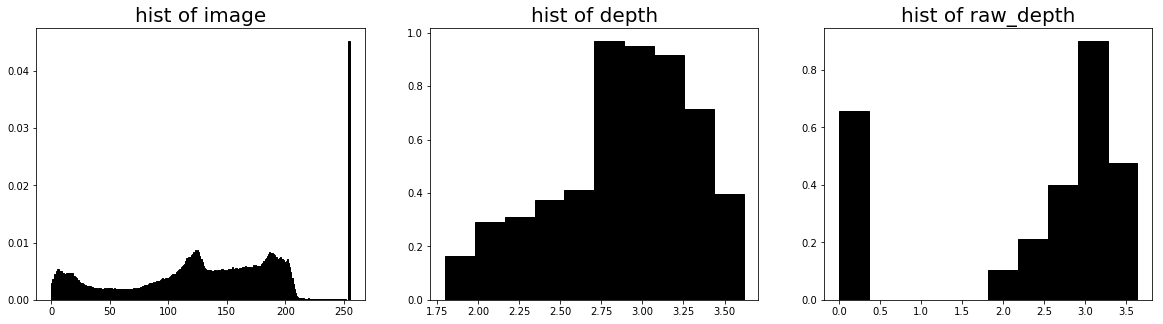

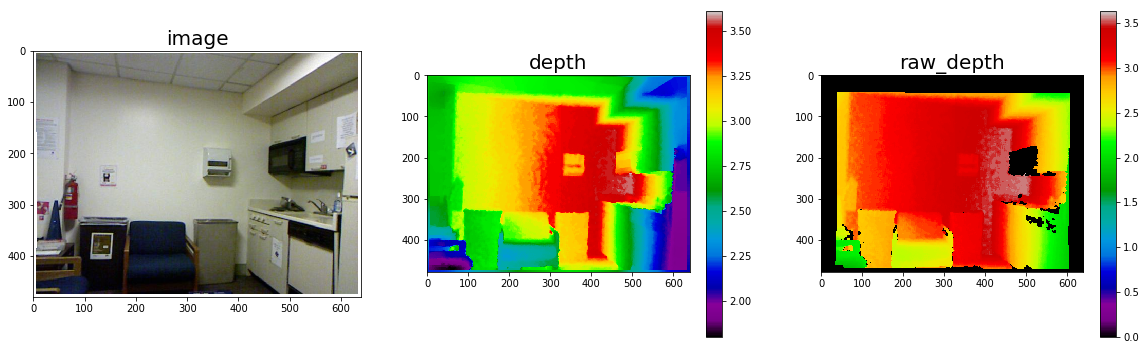

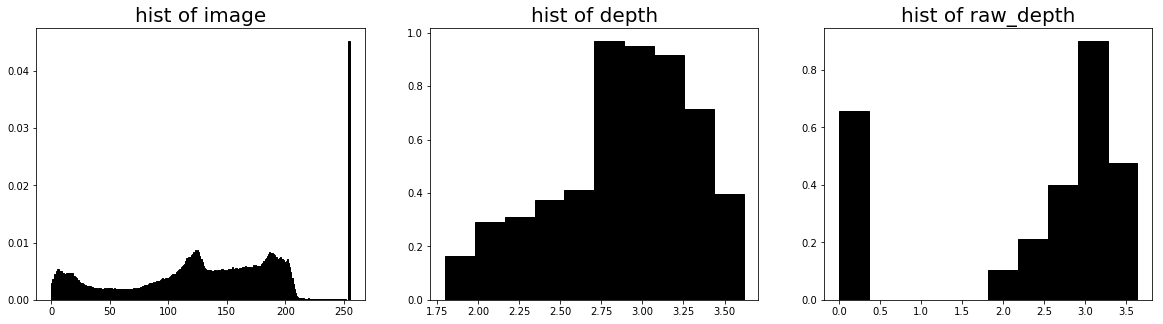

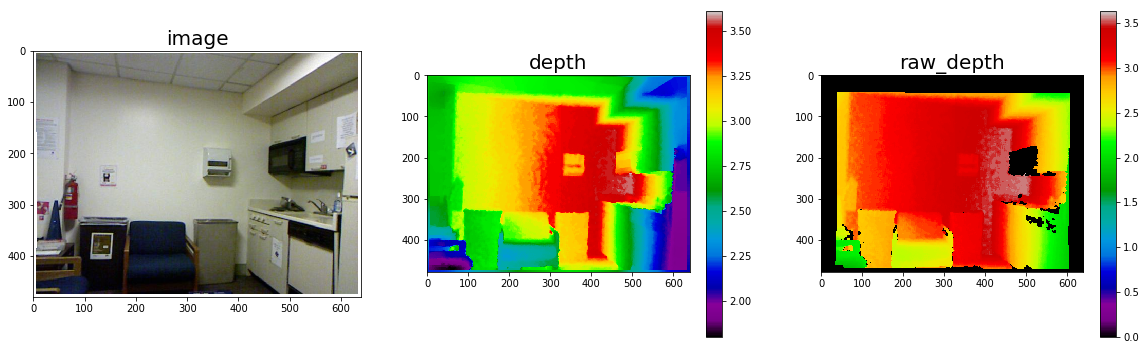

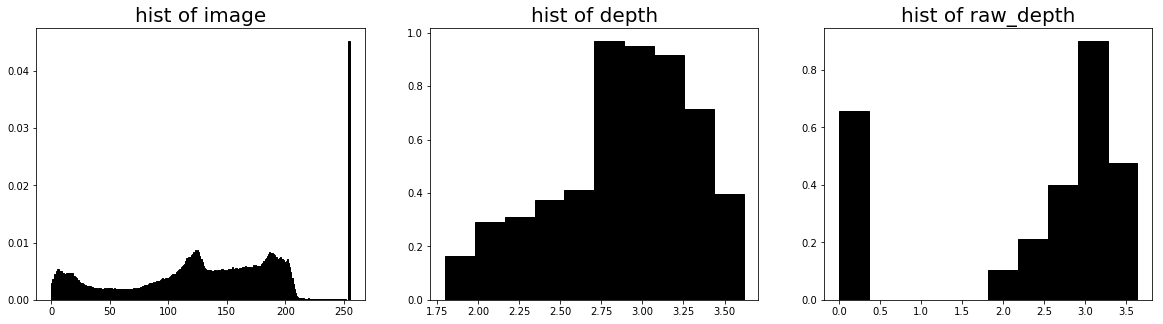

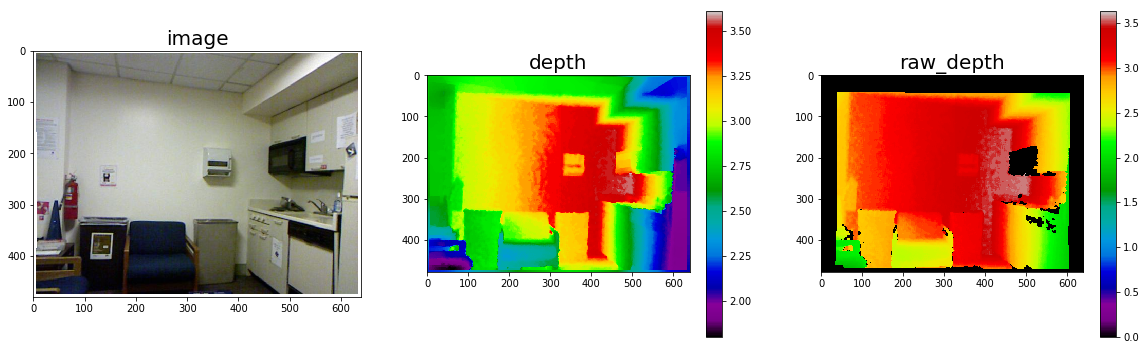

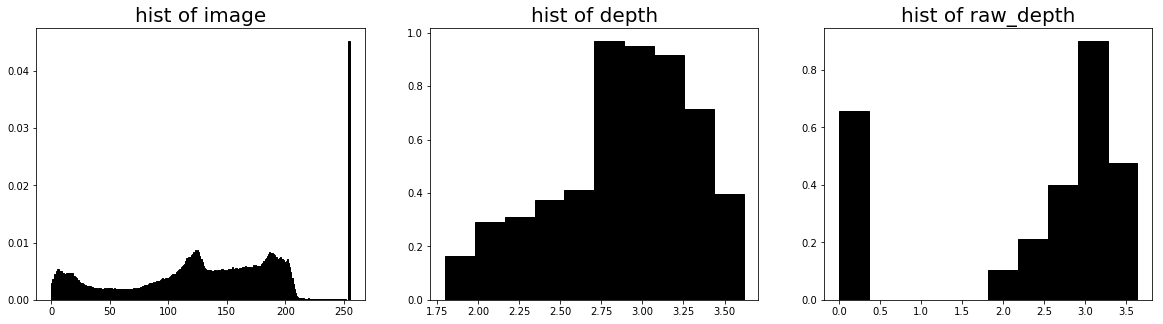

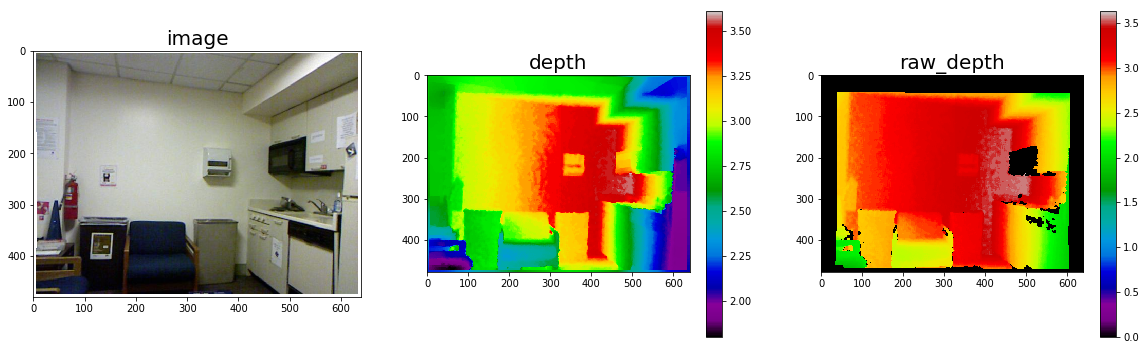

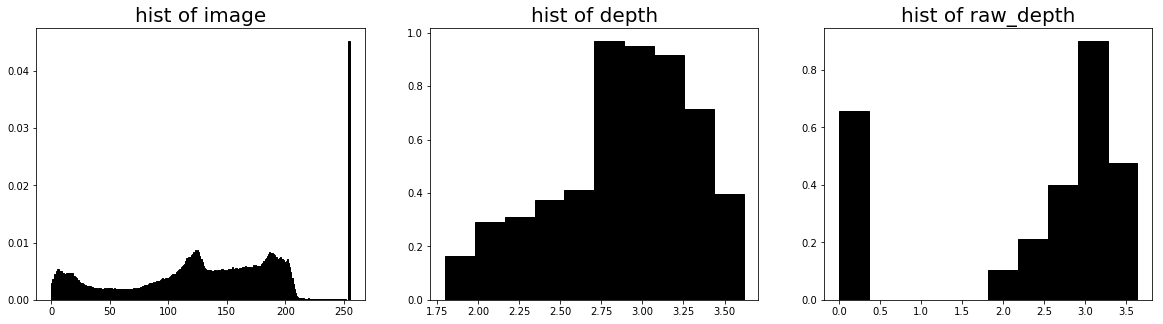

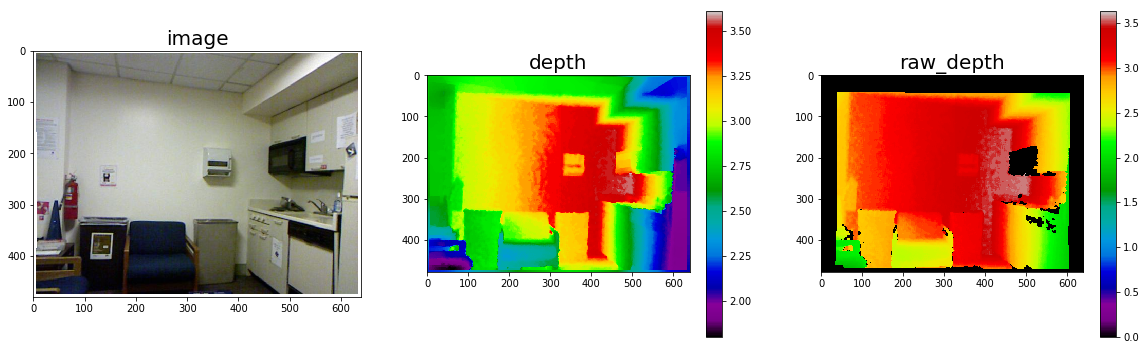

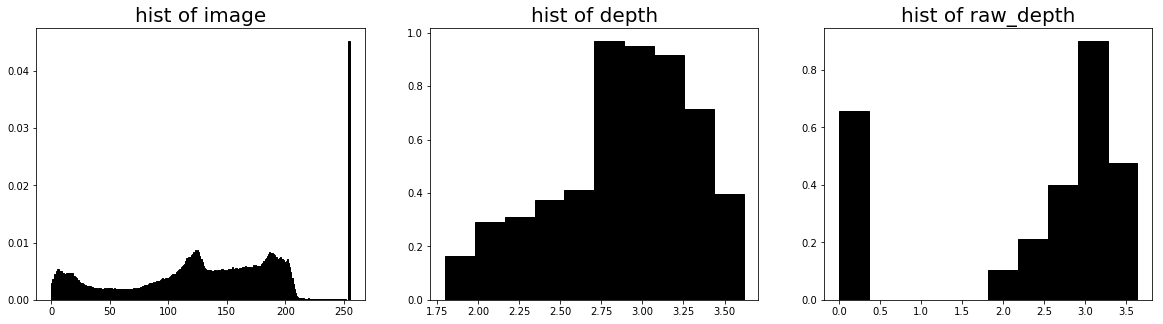

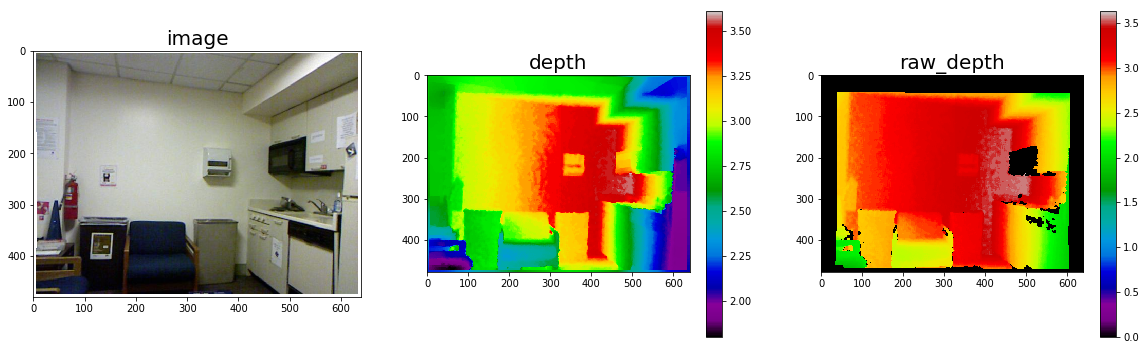

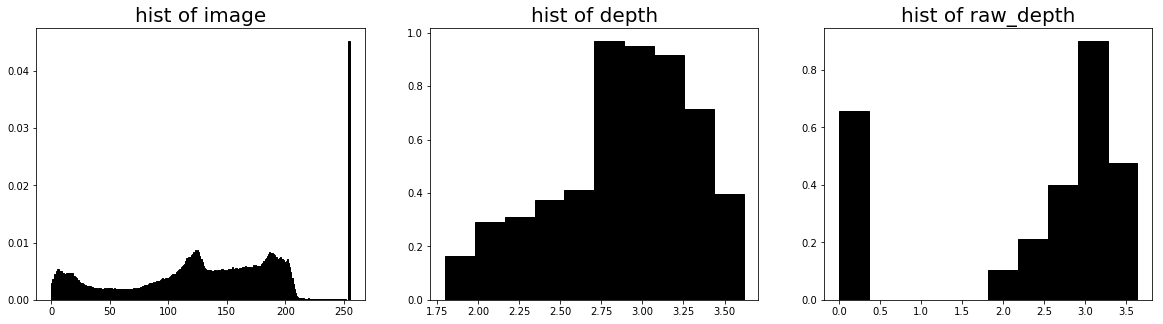

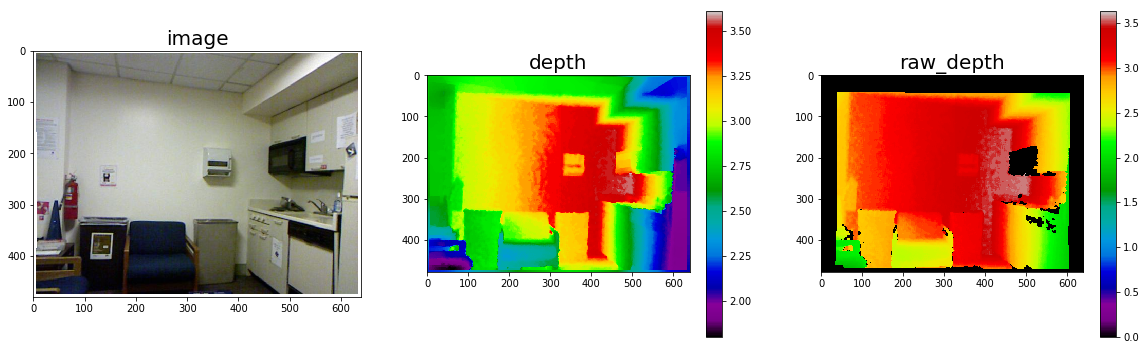

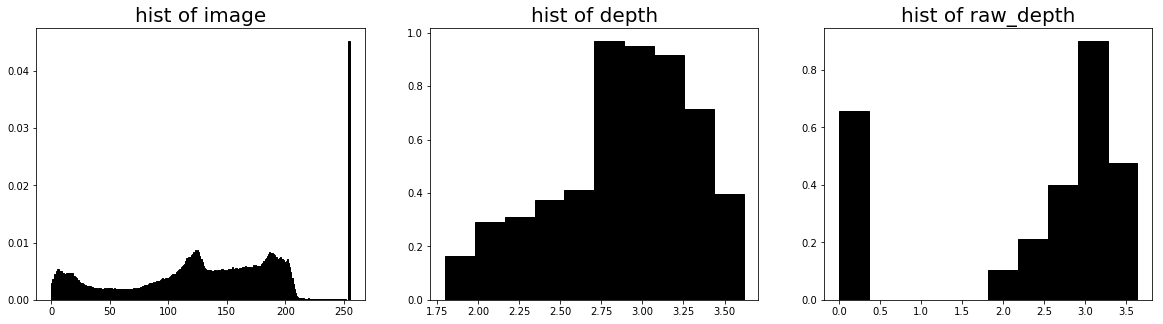

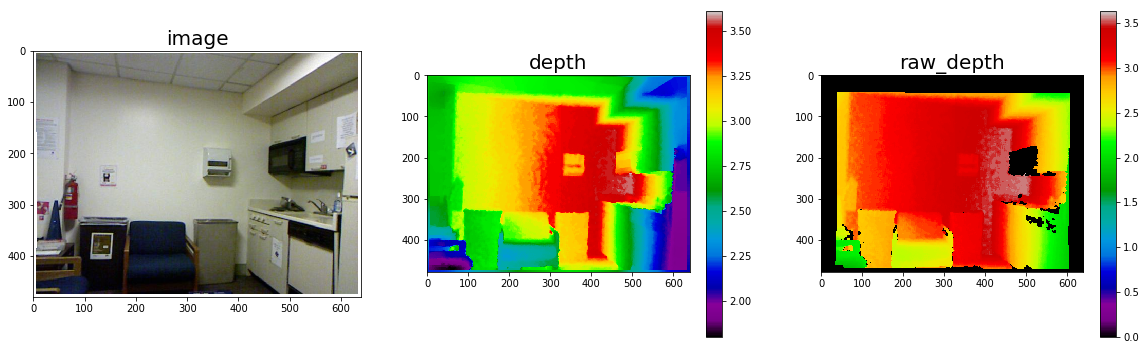

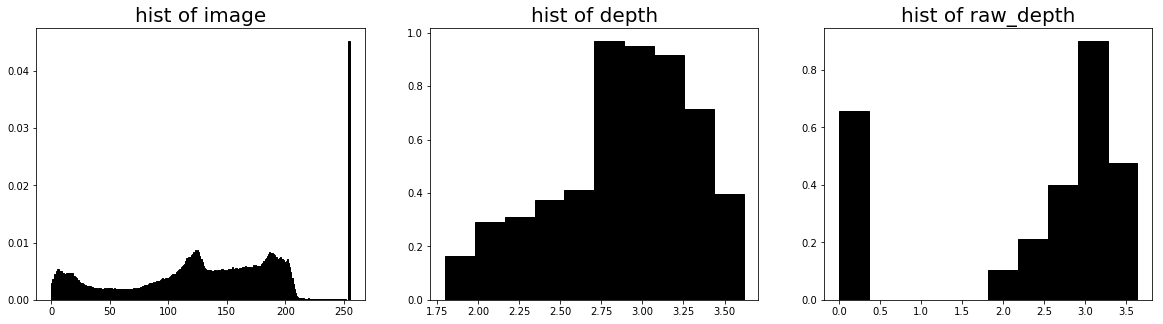

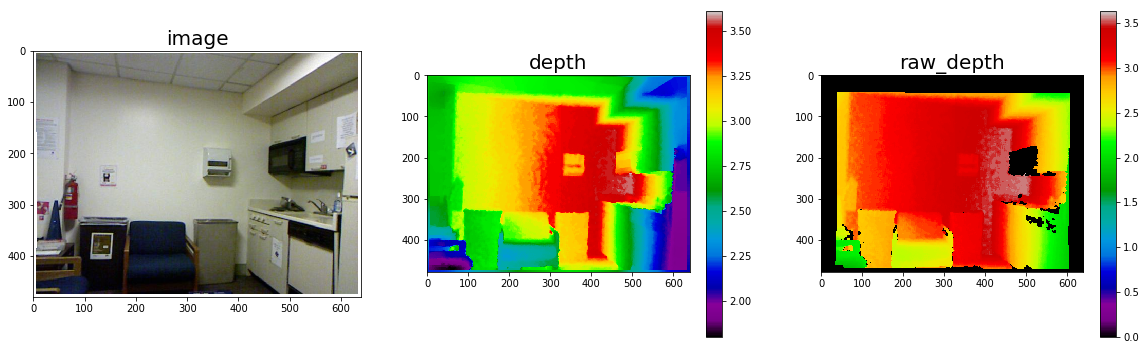

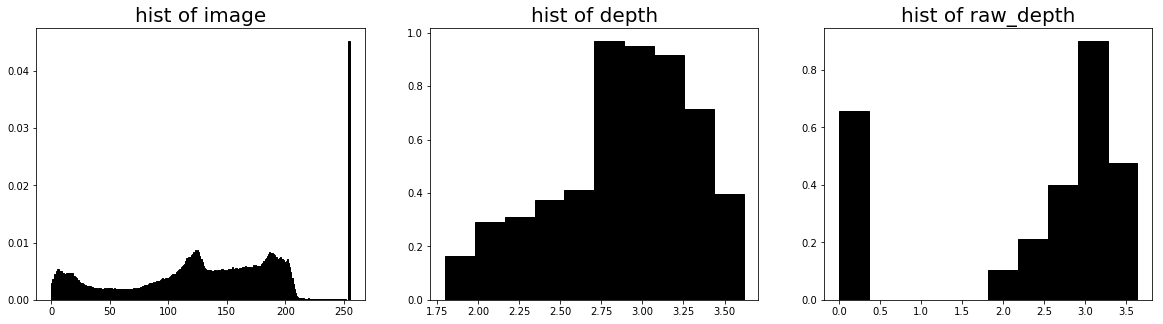

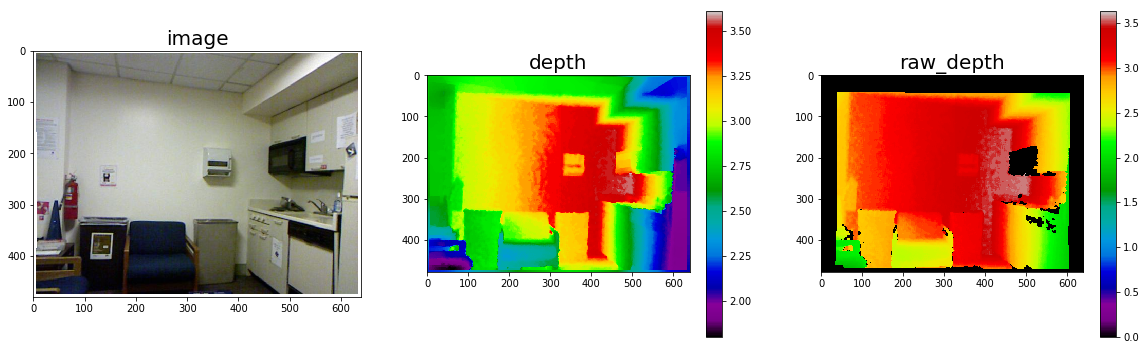

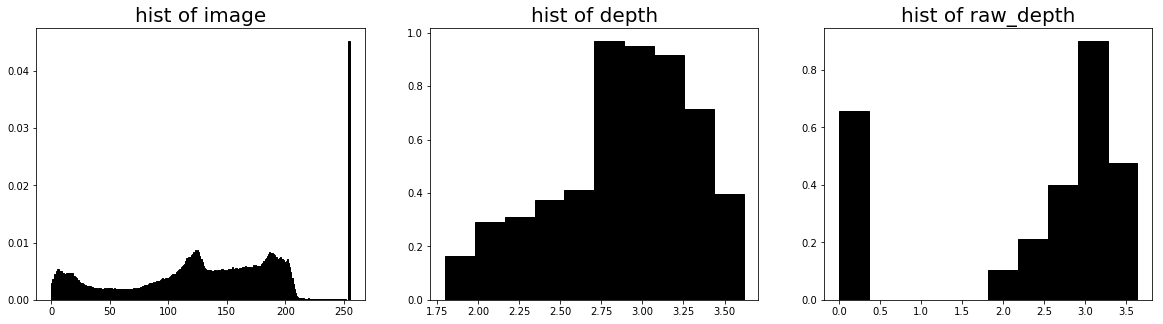

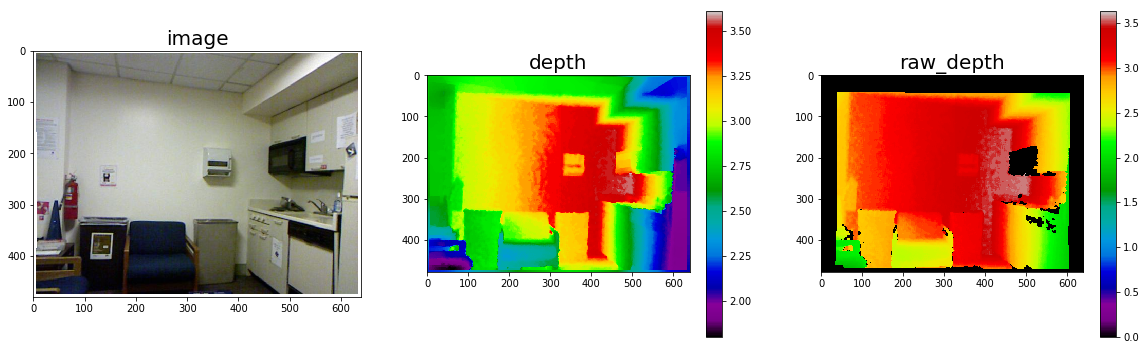

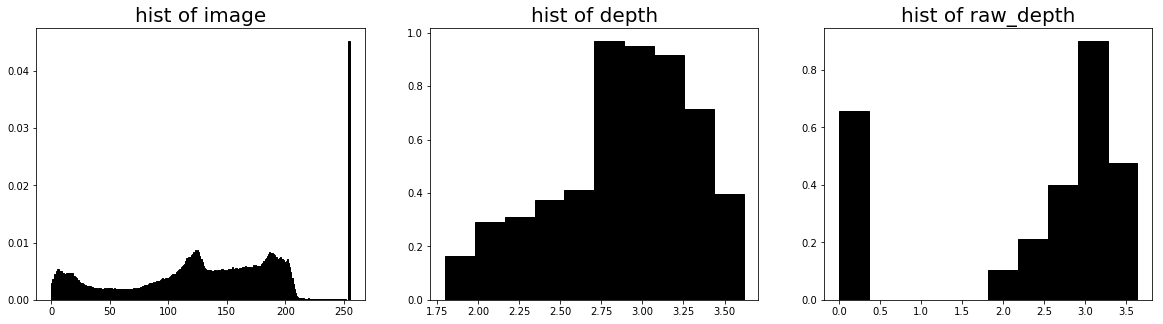

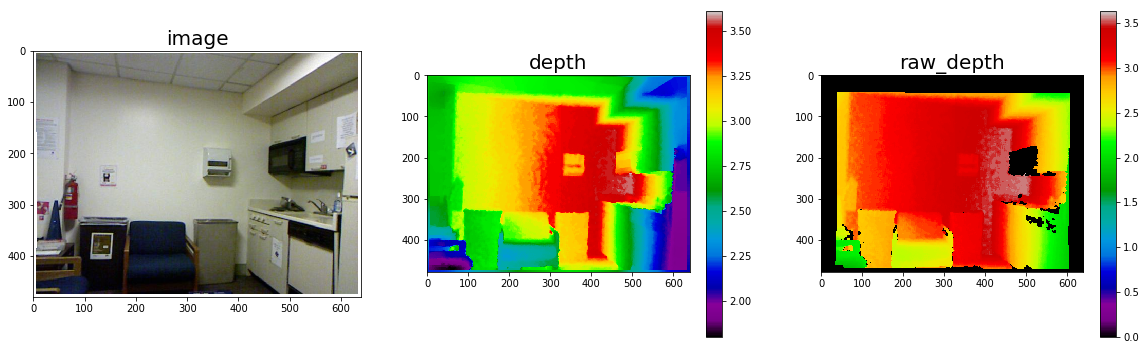

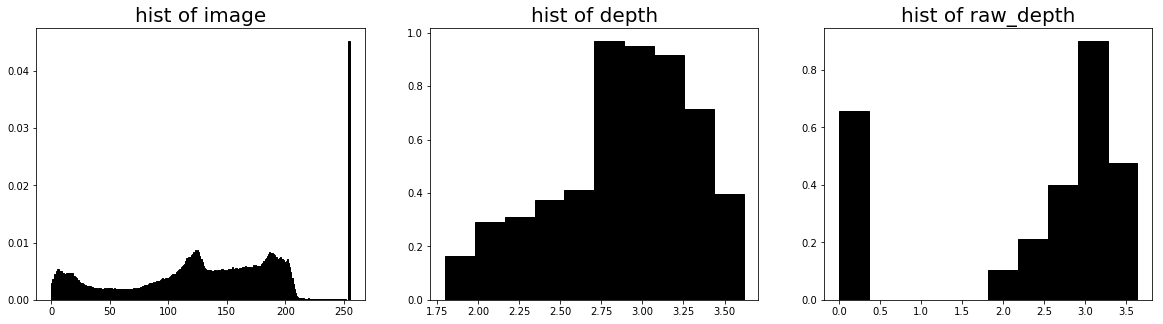

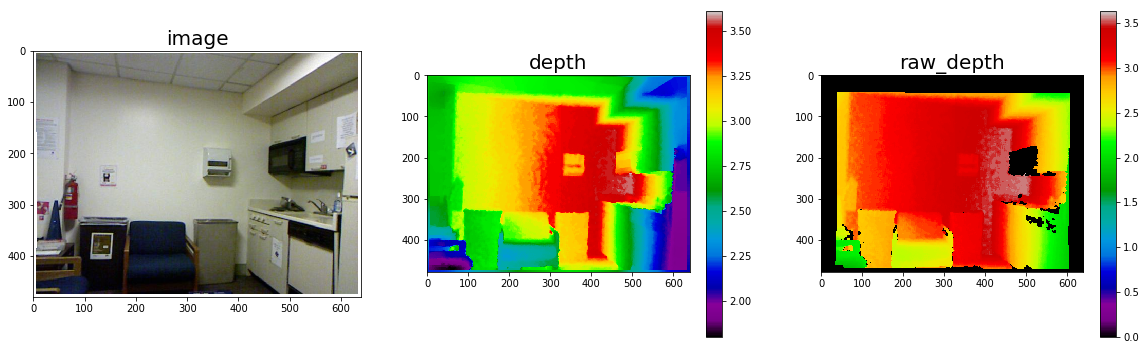

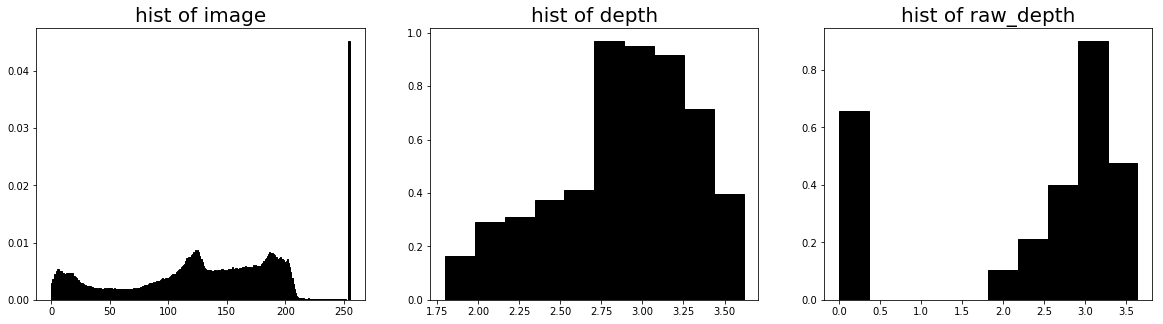

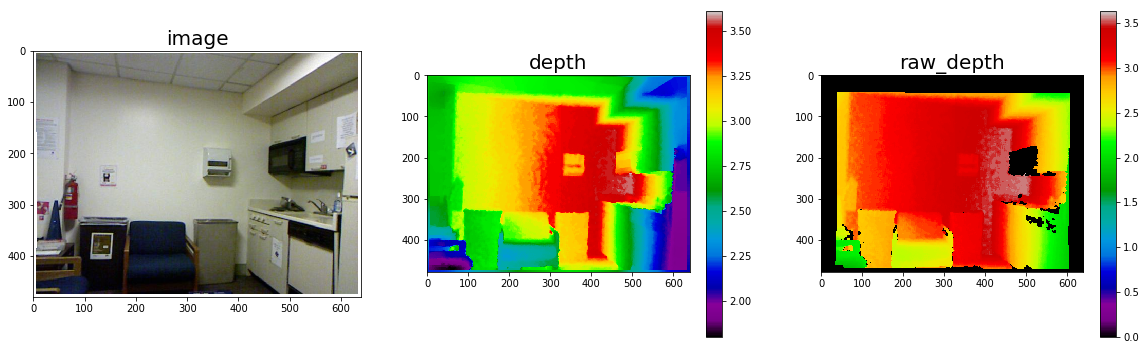

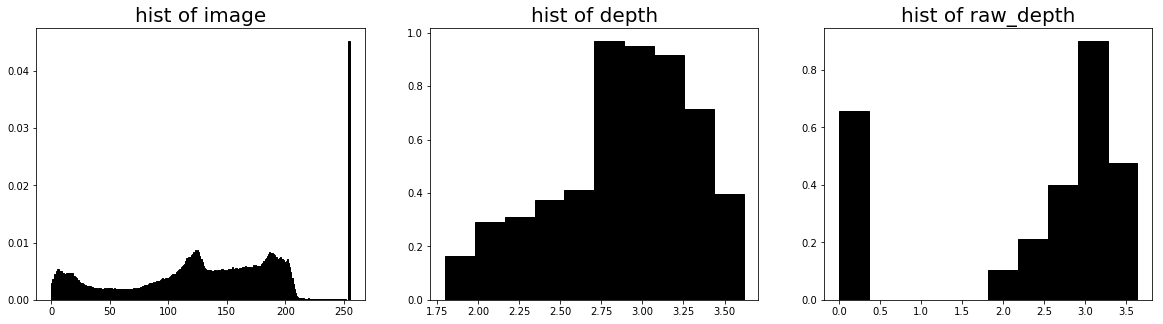

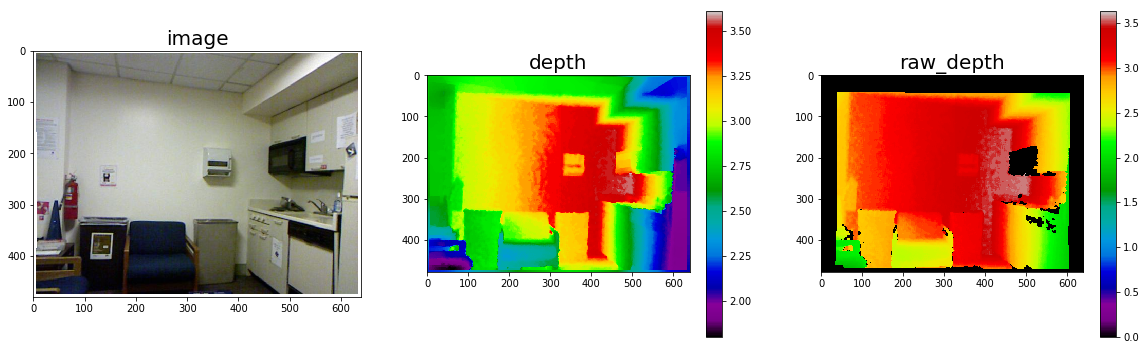

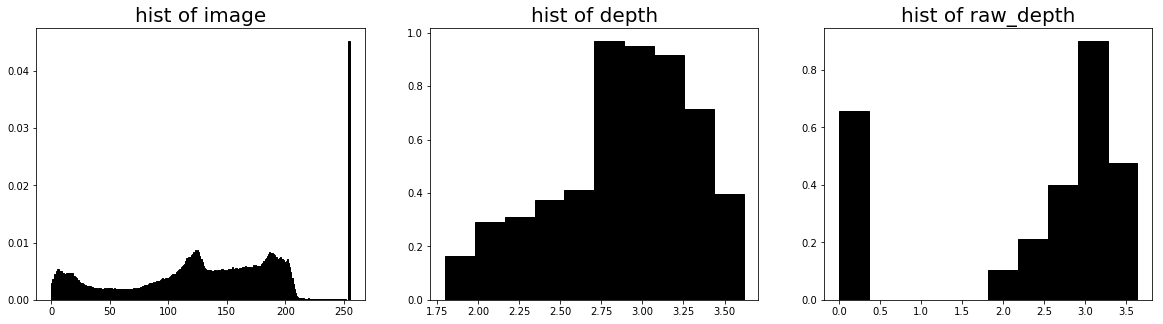

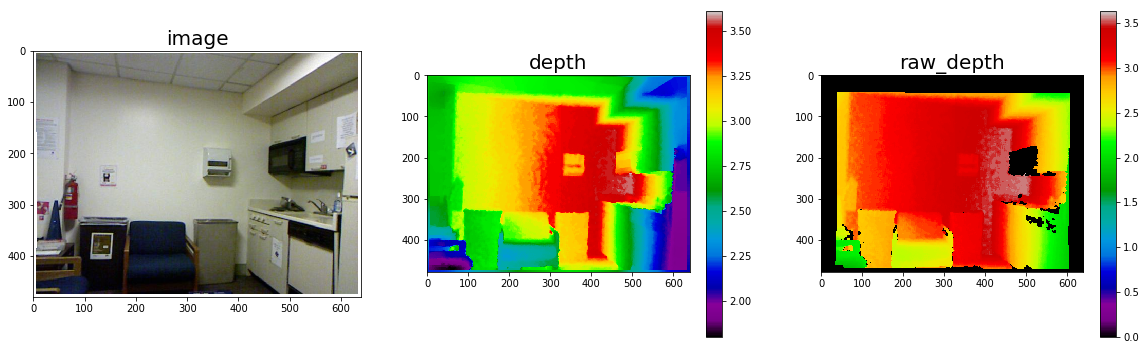

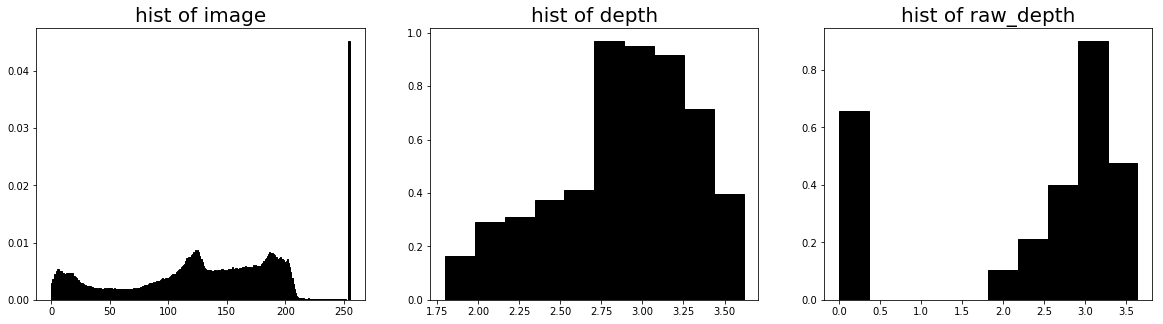

In [8]:
for index in range(0, 1499, 80):
    img, depth, raw_depth = get_image(NYU_Depth_v2, 0)
    visualize_image(img, depth, raw_depth)
    visualize_image_histogram(img, depth, raw_depth)

## The END